# PCA Strategy: Flatteners and Steepeners

Given the PCA Var-Cov decomposition, we are going to conduct a strategy that is neutral to changes in the level of the curve (PC1 neutral), and delta neutral. 

Our PCA decomposition looks like the following:

$$  F_t = \Delta y_{t} E$$
$$ \Delta y_{t} = F_t E^T$$ 

Where:

- $\Delta y_t$ is $(n, m)$ matrix with $n =$ number of periods in-sample and $m$ maturities in our yield curve (30).
- $F_t$ is the  $(n, f)$ matrix  of series of PCA scores, with $f$ number of factors to project (3 in our baseline case, ~97\% variance explained)
- $E$ $(f, m)$ matrix of eigenvectors of the decomposition of $\Sigma$, i.e. the loading of each PCA factor of each maturity. 

## Steepeners and Flatteners

The two strategies that we will pursue are Steepeners and Flatteners:

- Steepener:
    - Upward sloping curve: long front end /short long end 
- Flattener: 
    - Upward sloping curve: short front end /long long end

We choose a set of pairs of shorter/longer rates, such as 2vs20, 6Mvs5Y, 3Mvs7Y and so on. For any pair, we defined a portfolio with weights $w_1, w_2$ such that the $i$-th portfolio strategy $ i = 1,....,N$, $\Pi^i_t$, is neutral to $\text{PCA}_1$ factor: 

$$ \Pi^i_t =  w_1 \cdot \Delta y^s_t + w_2 \cdot \Delta y^l_t$$
$$ \partial_{\text{PCA}_1} \Pi^i_t = w_1 \partial_{\text{PCA}_1} \Delta y^s_t + w_2\partial_{\text{PCA}_1}\Delta y^l_t = 0 $$

We know that from the PCA decompositions $\partial_{\text{PCA}_1} \Delta y^s_t = E_{(1, \Delta y^j_t)}, j = s,l$, the respective loading from the eigenvectors. Furthermore, we restrict $w_1 + w_2 = 0$ or $w_1 = -w_2$ to have a delta nuetral portfolio.

$$ w_1 \partial_{\text{PCA}_1} \Delta y^s_t + w_2\partial_{\text{PCA}_1}\Delta y^l_t = 0$$
$$ w_1 E_{(1, \Delta y^s_t)} + w_2 E_{(1, \Delta y^l_t)} = 0$$

Additionally, we would like to have unit exposure to PCA2:

$$ w_1 E_{(2, \Delta y^s_t)} + w_2 E_{(2, \Delta y^l_t)} = 1$$


## Entry signal


Our entry signal is dervied from the Z-score of the portfolio given, where the mean and standard deviation are derived from a fix (but probably rolling) window, as:

$$\text{Z-score}^i = \frac{\Pi^t - \bar{\Pi^i}}{\sigma_{\Pi^i}}$$


We would enter a trade for $\text{Z-score} \geq |2|$ two or more standar deviation events. 









# Vizualization of strategy

In what follows we use as example the spread 2vs10Y swap rate (spot).

In [26]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import module_joaquin as mod

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
spot_df = pd.read_csv("data/spot_sofr.csv",
                      parse_dates=["Dates"], header=0)
spot_df = spot_df.set_index("Dates")
spot_df = spot_df.apply(pd.to_numeric, errors="coerce").dropna()
print("Start date in sample = {t}".format(t = spot_df.index[0].strftime("%A, %B %d, %Y")))
print("End date in sample = {t}".format(t = spot_df.index[-1].strftime("%A, %B %d, %Y")))
print("Number of daily observations = {n}".format(n = spot_df.shape[0]))
print("Number of maturities = {m}".format(m = spot_df.shape[1]))
print("Maturities = {ml}".format(ml = list(spot_df.columns)))

Start date in sample = Friday, January 01, 2021
End date in sample = Friday, October 31, 2025
Number of daily observations = 1227
Number of maturities = 30
Maturities = ['1W', '2W', '3W', '1M', '2M', '3M', '4M', '5M', '6M', '7M', '8M', '9M', '10M', '11M', '12M', '18M', '2Y', '3Y', '4Y', '5Y', '6Y', '7Y', '8Y', '9Y', '10Y', '12Y', '15Y', '20Y', '25Y', '30Y']


<Axes: >

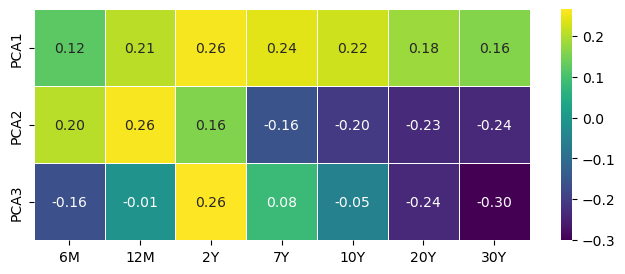

In [32]:
from sklearn.decomposition import PCA

spot_diff = spot_df.diff(1).dropna()
n_mats = len(spot_diff.columns)

train_start_date = "2021-01-01"
train_end_date = "2023-12-29"
test_start_date = "2024-01-01"
test_end_date = "2025-10-31"

training_sample = spot_diff.loc[train_start_date:train_end_date]
test_sample = spot_diff.loc[test_start_date:test_end_date]
pca = PCA(n_components=3).fit(training_sample)
E_matrix = pca.components_

selected_maturities = ["6M", "12M", "2Y", "7Y", "10Y", "20Y", "30Y"]

E_display = pd.DataFrame(E_matrix, columns=spot_diff.columns, index=["PCA1", "PCA2", "PCA3"])[selected_maturities]
plt.figure(figsize=(8, 3))
sns.heatmap(E_display, annot=True, cmap='viridis', fmt=".2f", linewidths=.5)
